In [17]:
import numpy as np

#constant 
r_0 = 387.4 #https://www.wolframalpha.com/input/?i=161.9+atomic+mass+unit+*+mu_0+*+%289.93+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+in+bohr+radius 
mu_m = 1.E-06 / (r_0 * 0.529E-10)

#input parameters


a_11 = 70 / r_0
a_22 = 70 / r_0
a_12 = 69 / r_0 #variable



In [18]:

g_11 = 4*np.pi*a_11
g_22 = 4*np.pi*a_22
g_12 = 4*np.pi*a_12 #mass is the same
c_lhy = 8/(15*np.sqrt(2*np.pi * (4*np.pi)**3))

n_max = 1
n_grid_densities = 256
n_grid_theta = 256

n_a = np.linspace(0, n_max, num = n_grid_densities)
n_b = n_a
n1, n2 = np.meshgrid(n_a, n_b, indexing='ij')

theta = np.linspace(0., np.pi, num = n_grid_theta)
sin_theta = np.sin(theta)
eta_11 = g_11 + 4*np.pi/3 * (3 * np.cos(theta)**2 - 1)
eta_22 = g_22 + 4*np.pi/3 * (3 * np.cos(theta)**2 - 1)
eta_12 = g_12 + 4*np.pi/3 * (3 * np.cos(theta)**2 - 1)


def V_lambda(den1, den2):
    v1 = eta_11 * den1 + eta_22 * den2
    v2 = np.sqrt((eta_11*den1 - eta_22*den2)**2 + 4*eta_12**2 * den1*den2)
    return c_lhy * (v1 + v2) + 0.j , c_lhy * (v1 - v2) + 0.j

def d_V_lambda(den1, den2):
    d1, d2, d3, d4 = eta_11*np.ones(np.shape(den1)), eta_11*np.ones(np.shape(den1)), eta_22*np.ones(np.shape(den1)), eta_22*np.ones(np.shape(den1))
    
    d1_help  = (eta_11 * den1 - eta_22 * den2) * eta_11 + 2*eta_12**2 * den2
    d1_help /= np.sqrt((eta_11 * den1 - eta_22 * den2)**2 + 4*eta_12**2 * den1 * den2)

    d2_help  = -(eta_11 * den1 - eta_22 * den2) * eta_22 + 2*eta_12**2 * den1
    d2_help /= np.sqrt((eta_11 * den1 - eta_22 * den2)**2 + 4*eta_12**2 * den1 * den2)

    d1 += d1_help
    d2 -= d1_help
    d3 += d2_help
    d4 -= d2_help
    
    return d1, d2, d3, d4

def get_en_lhy(den1, den2):
    dt = theta[1] - theta[0]
    den1, den2 = np.expand_dims(den1, 2), np.expand_dims(den2, 2)
    v1, v2 = V_lambda(den1, den2)
    return c_lhy * dt * np.sum( (v1**2.5 + v2**2.5) * sin_theta, axis=2).real

def get_mu_lhy(den1, den2):
    dt = theta[1] - theta[0]
    den1, den2 = np.expand_dims(den1, 2), np.expand_dims(den2, 2)
    v1, v2 = V_lambda(den1, den2)
    d1, d2, d3, d4 = d_V_lambda(den1, den2)

    mu_a = c_lhy * dt * np.sum( 2.5 * (v1**1.5*d1 + v2**1.5*d2) * sin_theta, axis=2)
    mu_b = c_lhy * dt * np.sum( 2.5 * (v1**1.5*d3 + v2**1.5*d4) * sin_theta, axis=2)
    return mu_a.real, mu_b.real


en_lhy = np.nan_to_num(get_en_lhy(n1, n2), 0)
print(np.shape(en_lhy))
mu_a, mu_b = get_mu_lhy(n1, n2)

mu_a = np.nan_to_num(mu_a, 0)
mu_b = np.nan_to_num(mu_b, 0)


(256, 256)
<ipython-input-18-f79d32afc795>:30: RuntimeWarning: invalid value encountered in true_divide
  d1_help /= np.sqrt((eta_11 * den1 - eta_22 * den2)**2 + 4*eta_12**2 * den1 * den2)
<ipython-input-18-f79d32afc795>:33: RuntimeWarning: invalid value encountered in true_divide
  d2_help /= np.sqrt((eta_11 * den1 - eta_22 * den2)**2 + 4*eta_12**2 * den1 * den2)


In [19]:
from scipy import interpolate
#lhy_interpolation = interpolate.interp2d(n1.ravel(), n2.ravel(), en_lhy.ravel(), kind='cubic')
lhy_interpolation = interpolate.RectBivariateSpline(n_a, n_b, en_lhy)
mu_a_interpolation = interpolate.RectBivariateSpline(n_a, n_b, mu_a)
mu_b_interpolation = interpolate.RectBivariateSpline(n_a, n_b, mu_b)
print("interpolation finished")

import pickle
with open('interpolator_lhy_energy.pkl', 'wb') as f:
    pickle.dump(lhy_interpolation, f)
with open('interpolator_mu_a.pkl', 'wb') as f:
    pickle.dump(mu_a_interpolation, f)
with open('interpolator_mu_b.pkl', 'wb') as f:
    pickle.dump(mu_b_interpolation, f)  


interpolation finished


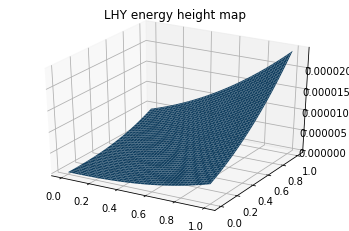

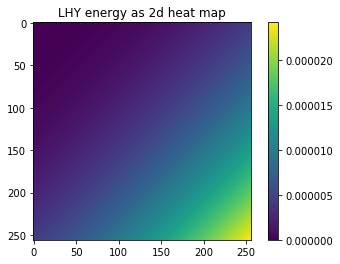

In [20]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# show hight map in 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(n1, n2, en_lhy)
plt.title('LHY energy height map')
plt.show()

# show hight map in 2d
plt.figure()
plt.title('LHY energy as 2d heat map')
p = plt.imshow(en_lhy)
plt.colorbar(p)
plt.show()

In [21]:
#print(en_lhy(0.1, 0.2))
print(lhy_interpolation(0.1, 0.2), lhy_interpolation([0.1, 0.2], [0.2, 0.3], grid=False))

[[2.11196512e-07]] [2.11196512e-07 7.57069232e-07]


In [22]:
x = np.linspace(0, 1, 32**3)
#%timeit lhy_interpolation(x, x, grid=False)
x = np.linspace(0, 1, 32)
x, x, x = np.meshgrid(x, x, x)
#%timeit np.fft.fftn(x)

In [23]:
print(np.shape(lhy_interpolation(n1,n1, grid=False)))

(256, 256)


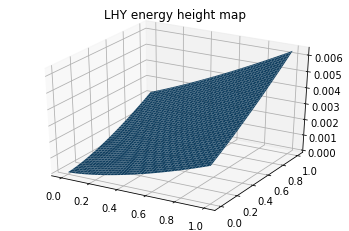

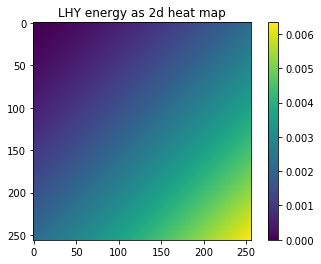

In [24]:
# show hight map in 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(n1, n2, mu_a)
plt.title('mu_a height map')
plt.show()

# show hight map in 2d
plt.figure()
plt.title('mu_a as 2d heat map')
p = plt.imshow(mu_a)
plt.colorbar(p)
plt.show()